# Plant Classification

# Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms # for processing datasets
from torch.utils.data import DataLoader # for making dataset easier to use 

from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [2]:
# hypter parameter setting
learning_rate = 1e-3 # 어려운 데이터는 learning rate 10의-3승~4승정도로 해줘야 함
training_epochs = 100
display_step = 10
batch_size = 64
activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2) # kernel size, stride size, padding size 
dropout_rate = 0.5

# Load data & Pre-process data

In [3]:
trans = transforms.Compose([transforms.Resize(32), transforms.ToTensor()]) 
dataset = torchvision.datasets.ImageFolder(root = 'C:/Users/pirl/Desktop/aicontest/NIPA_하반기 경진대회_사전검증/train', transform = trans) 

In [4]:
len(dataset)*(6/8), len(dataset)*(2/8) # train:validation:test = 6:2:2

(12000.0, 4000.0)

len(train_data):  12000
len(val_data):  4000
data tensor([[[0.3725, 0.3451, 0.3725],
         [0.3922, 0.3647, 0.3922],
         [0.4078, 0.3804, 0.4078],
         ...,
         [0.5961, 0.5686, 0.5961],
         [0.5961, 0.5686, 0.5961],
         [0.5882, 0.5608, 0.5882]],

        [[0.3804, 0.3529, 0.3804],
         [0.4078, 0.3804, 0.4078],
         [0.4275, 0.4000, 0.4275],
         ...,
         [0.6157, 0.5882, 0.6157],
         [0.6078, 0.5804, 0.6078],
         [0.5961, 0.5686, 0.5961]],

        [[0.3922, 0.3647, 0.3922],
         [0.4157, 0.3882, 0.4157],
         [0.4353, 0.4078, 0.4353],
         ...,
         [0.6275, 0.6000, 0.6275],
         [0.6235, 0.5961, 0.6275],
         [0.6157, 0.5882, 0.6196]],

        ...,

        [[0.6039, 0.5922, 0.6667],
         [0.6078, 0.5961, 0.6706],
         [0.6078, 0.5961, 0.6706],
         ...,
         [0.7490, 0.7412, 0.7961],
         [0.7490, 0.7412, 0.7961],
         [0.7490, 0.7412, 0.7961]],

        [[0.5843, 0.5725, 0.6549

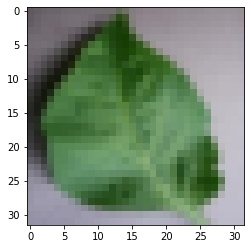

In [5]:
train_data, val_data = torch.utils.data.random_split(dataset, [int(len(dataset)*(6/8)), int(len(dataset)*(2/8))])

# check the data
print('len(train_data): ', len(train_data))
print('len(val_data): ', len(val_data))

x_train, y_train = train_data[0]
x_train = np.transpose(x_train, (1, 2, 0))

# 32 x 32 x 3

print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train)
plt.show()

data shape: torch.Size([64, 3, 32, 32])
label: tensor([ 7, 11, 11,  7,  2, 19, 11, 17, 13, 19,  4, 14, 16, 19, 18, 14, 11,  1,
         2,  7,  3,  5,  5,  1,  1,  2,  7, 14, 14,  9, 18,  5, 13, 10,  9, 15,
        12,  5, 14,  3, 14,  7,  0,  3,  9,  0, 13,  1,  1, 13,  1,  8,  0, 16,
        16, 15,  7,  9, 15,  5, 16, 17, 19, 12])


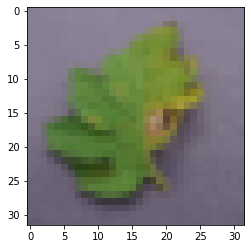

In [6]:
# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

check_image = example_data[0]
check_image = np.transpose(check_image, (1, 2, 0))

plt.figure()
plt.imshow(check_image)
plt.show()

# Model & Optimization and Loss function

In [7]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
if torch.cuda.is_available():
    model.cuda()

# Train & Validate

In [10]:
loss_array = []

# train the model
for i in range(training_epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 2.5942652225494385
10 epoch loss: 0.2181917428970337
20 epoch loss: 0.16155585646629333
30 epoch loss: 0.06668789684772491
40 epoch loss: 0.022440414875745773
50 epoch loss: 0.01603216491639614
60 epoch loss: 0.005743006244301796
70 epoch loss: 0.14523234963417053
80 epoch loss: 0.13010482490062714
90 epoch loss: 0.12271089106798172


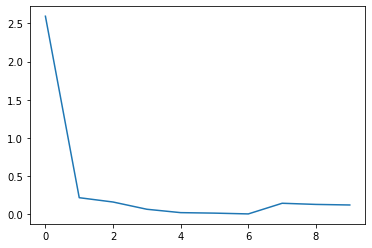

In [11]:
plt.figure()
plt.plot(loss_array)
plt.show()

### Accuracy

In [12]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(val_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()
        
        val_accuracy = correct/total

print("Validation accuraccy: {}".format(val_accuracy))

Validation accuraccy: 0.8863406777381897


In [13]:
len(prediction_list), len(label_list)

(62, 62)

In [14]:
y_pred = []
for prediction in prediction_list:
    prediction = prediction.tolist()
    y_pred += prediction
y_pred

[16,
 17,
 10,
 12,
 16,
 9,
 14,
 9,
 1,
 11,
 10,
 0,
 16,
 16,
 15,
 9,
 10,
 1,
 17,
 12,
 16,
 10,
 19,
 17,
 6,
 19,
 17,
 5,
 19,
 13,
 12,
 19,
 18,
 17,
 17,
 10,
 1,
 10,
 2,
 4,
 8,
 9,
 14,
 1,
 17,
 4,
 13,
 15,
 8,
 7,
 15,
 17,
 15,
 16,
 5,
 2,
 0,
 8,
 2,
 16,
 11,
 8,
 1,
 13,
 15,
 9,
 0,
 13,
 4,
 5,
 3,
 10,
 15,
 9,
 14,
 0,
 9,
 14,
 19,
 18,
 13,
 5,
 6,
 17,
 19,
 4,
 16,
 3,
 14,
 19,
 3,
 3,
 13,
 0,
 13,
 13,
 19,
 0,
 8,
 15,
 0,
 6,
 2,
 11,
 12,
 2,
 5,
 17,
 7,
 17,
 5,
 4,
 9,
 15,
 2,
 5,
 19,
 12,
 16,
 13,
 11,
 2,
 5,
 5,
 1,
 10,
 14,
 10,
 5,
 19,
 4,
 10,
 13,
 13,
 3,
 7,
 10,
 6,
 16,
 9,
 0,
 8,
 15,
 8,
 13,
 0,
 9,
 19,
 2,
 4,
 6,
 0,
 6,
 9,
 5,
 1,
 10,
 12,
 13,
 16,
 1,
 8,
 16,
 12,
 12,
 9,
 18,
 1,
 16,
 6,
 10,
 12,
 2,
 2,
 8,
 4,
 11,
 5,
 3,
 7,
 7,
 16,
 13,
 12,
 7,
 3,
 18,
 15,
 7,
 14,
 3,
 9,
 12,
 19,
 18,
 16,
 3,
 16,
 8,
 16,
 14,
 18,
 9,
 16,
 18,
 10,
 2,
 6,
 18,
 10,
 0,
 18,
 15,
 1,
 5,
 19,
 8,
 1,
 7,
 13,
 15,

In [15]:
y_true = []
for label in label_list:
    label = label.tolist()
    y_true += label
y_true

[17,
 17,
 10,
 10,
 16,
 9,
 14,
 9,
 1,
 11,
 10,
 0,
 16,
 16,
 15,
 9,
 10,
 1,
 17,
 12,
 16,
 10,
 19,
 17,
 6,
 8,
 17,
 5,
 19,
 13,
 12,
 7,
 18,
 17,
 17,
 10,
 1,
 10,
 2,
 4,
 8,
 9,
 14,
 1,
 17,
 4,
 13,
 15,
 8,
 7,
 15,
 17,
 15,
 17,
 5,
 2,
 0,
 8,
 2,
 16,
 11,
 9,
 1,
 13,
 15,
 9,
 0,
 13,
 4,
 5,
 3,
 10,
 15,
 9,
 14,
 0,
 9,
 14,
 19,
 18,
 13,
 6,
 6,
 17,
 19,
 5,
 16,
 3,
 14,
 19,
 3,
 3,
 13,
 0,
 13,
 13,
 19,
 0,
 8,
 15,
 0,
 6,
 2,
 11,
 12,
 2,
 5,
 17,
 7,
 17,
 18,
 4,
 9,
 15,
 2,
 5,
 16,
 12,
 16,
 5,
 11,
 2,
 5,
 5,
 1,
 10,
 14,
 10,
 6,
 19,
 4,
 10,
 13,
 13,
 3,
 7,
 10,
 6,
 16,
 7,
 0,
 8,
 15,
 8,
 13,
 0,
 9,
 19,
 2,
 4,
 6,
 0,
 17,
 9,
 5,
 1,
 10,
 12,
 13,
 16,
 1,
 8,
 16,
 12,
 12,
 9,
 18,
 1,
 16,
 6,
 10,
 12,
 2,
 2,
 8,
 4,
 11,
 5,
 3,
 7,
 7,
 16,
 13,
 12,
 7,
 3,
 18,
 15,
 2,
 14,
 3,
 9,
 12,
 19,
 18,
 16,
 3,
 16,
 8,
 16,
 14,
 18,
 9,
 16,
 18,
 10,
 2,
 6,
 18,
 10,
 0,
 18,
 15,
 1,
 7,
 19,
 8,
 1,
 7,
 13,
 15,


### F1 score

In [16]:
# 'macro' : multiclass + 데이터 불균형 고려 X
metrics.f1_score(y_true, y_pred, average='macro')

0.8859222654887373

### Test

In [17]:
import os

path_dir = './NIPA_하반기 경진대회_사전검증/test'
file_list = os.listdir(path_dir)
file_list = [int(file.split('.')[0]) for file in file_list if file.endswith(".jpg")] # .jpg 파일만 리스트로 저장
file_list[:5], len(file_list)

([0, 1, 10, 100, 1000], 4096)

In [18]:
# index 순서대로 리스트 정렬
file_list.sort()
file_list[:5]

[0, 1, 2, 3, 4]

In [19]:
file_list = [str(file) + '.jpg' for file in file_list]

file_list[0:3]

['0.jpg', '1.jpg', '2.jpg']

In [20]:
from PIL import Image

testset = []
for file in file_list:
    path = './NIPA_하반기 경진대회_사전검증/test/{}'.format(file)
    image = Image.open(path)
    testset.append(image)
testset[0], len(testset)

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x16F8A4B87C8>,
 4096)

In [21]:
# Make fake image
if len(testset) % batch_size != 0:
    print("len(testset):", len(testset))
    print("batch_size:", batch_size)
    print("len(ttestset) / batch_size:", len(testset) / batch_size)
    print("We need data", (int(len(testset) / batch_size) + 1) * batch_size)
    fake_data_size = (int(len(testset) / batch_size) + 1) * batch_size - len(testset)
    print("We should make fake data", fake_data_size)
    
    fake_file_name_list = [str(index) + '.jpg' for index in list(range(len(testset), len(testset) + fake_data_size))]
    # fake_file_name_list[:3]
    
    for fake_file_name in fake_file_name_list:
        fake_img = Image.new('RGB', (256, 256))
        fake_img.save('./NIPA_하반기 경진대회_사전검증/test/{}'.format(fake_file_name))
    
    testset = []
    for file in file_list:
        path = './NIPA_하반기 경진대회_사전검증/test/{}'.format(file)
        image = Image.open(path)
        testset.append(image)
    print(testset[0], len(testset))

In [22]:
class CustomDataset(torch.utils.data.Dataset): 
    def __init__(self, transform):
        self.x_data = testset
        self.transform = transform
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx): 
        x = self.x_data[idx]
        x = self.transform(x)
        return x
    
test_data = CustomDataset(trans)
test_loader = DataLoader(test_data, batch_size = batch_size, drop_last = True)

In [23]:
test_data[0].shape

torch.Size([3, 32, 32])

In [24]:
# test the model
model.eval()
prediction_list = []

with torch.no_grad():
    for index, data in enumerate(test_loader):
        data = data.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)

### Save test.tsv to sub.tsv

In [25]:
y_pred_test = []
for prediction in prediction_list:
    prediction = prediction.tolist()
    y_pred_test += prediction
y_pred_test[:3], len(y_pred_test)

([0, 1, 12], 4096)

In [26]:
cls = {(3,5):0,(3,20):1,(4,2):2,(4,7):3,(4,11):4,(5,8):5,(7,1):6,
       (7,20):7,(8,6):8,(8,9):9,(10,20):10,(11,14):11,(13,1):12,
       (13,6):13,(13,9):14,(13,15):15,(13,16):16,(13,17):17,(13,18):18,(13,20):19}

inv_cls = {v: k for k, v in cls.items()}

In [27]:
new_line_list = []
with open('./NIPA_하반기 경진대회_사전검증/test/test.tsv', 'r') as f:
    line = f.readline()
    for pred in y_pred_test:
        if not line:
            break
        # print("pred:", pred)
        for classify_class in inv_cls.keys():
            # print("classify_class:", classify_class)
            if pred == classify_class:
                plant_label, disease_label = inv_cls[classify_class]
                new_line = '{}\t{}\t{}\n'.format(line.rstrip(), plant_label, disease_label)
                new_line_list.append(new_line)
                line = f.readline()

In [28]:
new_line_list[-1]

'3996.jpg\t11\t14\n'

In [29]:
len(new_line_list)

3997

In [30]:
with open('./NIPA_하반기 경진대회_사전검증/test/use_pretrained.tsv', 'w') as f:
    for new_line in new_line_list:
        f.write(new_line)